# DSM for Combinatorial Optimization (QUBO)

We study whether **denoising score matching (DSM)** can be adapted to solve a **Quadratic Unconstrained Binary Optimization (QUBO)** problem:

$$\max_{x\in\{0,1\}^n} E(x),\qquad E(x) = x^\top Q x,\; Q\in\mathbb{R}^{n\times n}.$$

## Energy-dependent noise DSM (CO-DSM)

Instead of the usual DSM perturbation $x+\sigma\varepsilon$, we use an **energy-scaled noise**:

$$\tilde x = x + \sigma\,E(x)\,\varepsilon,\qquad \varepsilon\sim\mathcal{N}(0,I).$$

And we train a score network $s_\theta(\tilde x,\sigma)$ with the objective

$$\mathcal{L}_{\mathrm{DSM}}^{\mathrm{CO}}(\theta)=\mathbb{E}_{x\sim p_{\mathrm{data}}}\,\mathbb{E}_{\sigma\sim\mathcal{P}(\sigma)}\,\mathbb{E}_{\varepsilon\sim\mathcal{N}(0,I)}\left[\left\|s_\theta\big(x+\sigma E(x)\varepsilon,\sigma\big)+\frac{\varepsilon}{\sigma E(x)}\right\|_2^2\right].$$

After training, we sample with **annealed Langevin dynamics** over a decreasing schedule of $\sigma$ and then project the final real-valued vector to $\{0,1\}^n$ by thresholding.

For report-ready plots, see the **2D / 3D toy cases** section.


## Setup

- Minimal deps: `torch`, `numpy`, `matplotlib`.
- Repro: run top-to-bottom; main knobs are `n`, `steps`, `batch_size`, `num_classes`, `n_steps_each`, `step_lr`.
- `device` is auto-detected (CPU/GPU).


In [1]:
import contextlib
import math
from dataclasses import dataclass
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
np.random.seed(0)
print("device:", device)

device: cuda


/Data/ncsnv2-env3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils


In [2]:
@contextlib.contextmanager
def temp_seed(seed: int):
    torch_state = torch.random.get_rng_state()
    np_state = np.random.get_state()
    cuda_state = torch.cuda.get_rng_state_all() if torch.cuda.is_available() else None
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    try:
        yield
    finally:
        torch.random.set_rng_state(torch_state)
        np.random.set_state(np_state)
        if cuda_state is not None:
            torch.cuda.set_rng_state_all(cuda_state)


def train_score_model(
    n_small: int,
    Q_small: torch.Tensor,
    sigmas: torch.Tensor,
    steps: int,
    batch_size: int,
    lr: float,
    hidden_dim: int,
    num_layers: int,
    anneal_power: float = 2.0,
):
    model_small = ScoreMLP(
        n=n_small,
        num_classes=sigmas.shape[0],
        hidden_dim=hidden_dim,
        num_layers=num_layers,
    ).to(device)
    opt = torch.optim.Adam(model_small.parameters(), lr=lr)
    model_small.train()
    loss_hist = []
    for _ in range(steps):
        x = sample_binary_batch(batch_size, n_small, device)
        loss = co_dsm_loss(model_small, x, Q_small, sigmas, anneal_power=anneal_power)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        loss_hist.append(float(loss.detach().cpu()))
    model_small.eval()
    return model_small, np.array(loss_hist)


@torch.no_grad()
def annealed_langevin_trace(
    model: nn.Module,
    sigmas: torch.Tensor,
    n: int,
    num_samples: int,
    n_steps_each: int,
    step_lr: float,
    device: torch.device,
    init: str = "gaussian",
):
    if init == "gaussian":
        x = torch.randn(num_samples, n, device=device)
    elif init == "uniform01":
        x = torch.rand(num_samples, n, device=device)
    else:
        raise ValueError(f"unknown init={init}")

    trace = [x.clone()]
    for c, sigma in enumerate(sigmas):
        labels = torch.full((num_samples,), c, device=device, dtype=torch.long)
        step_size = step_lr * (sigma / sigmas[-1]) ** 2
        for _ in range(n_steps_each):
            grad = model(x, labels)
            noise = torch.randn_like(x)
            x = x + step_size * grad + noise * math.sqrt(2.0 * step_size)
            trace.append(x.clone())
    return torch.stack(trace, dim=0)  # (T, B, n)


def plot_qubo_2d(Q2: torch.Tensor, trace_xy: torch.Tensor = None, res: int = 200):
    g = np.linspace(0.0, 1.0, res)
    X1, X2 = np.meshgrid(g, g)
    X = np.stack([X1.reshape(-1), X2.reshape(-1)], axis=1)
    X_t = torch.tensor(X, dtype=torch.float32, device=Q2.device)
    E = qubo_energy(X_t, Q2).view(res, res).detach().cpu().numpy()

    verts = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
    E_verts = qubo_energy(torch.tensor(verts, device=Q2.device), Q2).detach().cpu().numpy()
    best = verts[int(E_verts.argmax())]

    plt.figure(figsize=(6, 5))
    cf = plt.contourf(X1, X2, E, levels=30, cmap="viridis")
    plt.colorbar(cf, label="E(x)")
    plt.scatter(verts[:, 0], verts[:, 1], c=E_verts, cmap="magma", s=90, edgecolors="k")
    for (x1, x2), e in zip(verts, E_verts):
        plt.text(x1 + 0.03, x2 + 0.03, f"{e:.2f}", fontsize=9, color="white")
    plt.scatter([best[0]], [best[1]], marker="*", s=280, c="white", edgecolors="k", linewidths=1.0)

    if trace_xy is not None:
        t = trace_xy.detach().cpu().numpy()
        plt.plot(t[:, 0], t[:, 1], "-o", ms=2.5, lw=1.0, color="white")

    plt.title("2D: relaxed energy + binary vertices")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.tight_layout()
    plt.savefig("2D_energies.png", dpi=200, bbox_inches="tight")
    plt.show()


@torch.no_grad()
def plot_score_field_2d(
    model: nn.Module,
    sigma_index: int,
    quiver_res: int = 21,
    norm_res: int = 180,
):
    """2D score visualization: quiver field + score-norm heatmap on [0,1]^2."""
    if getattr(model, "n", None) != 2:
        raise ValueError("plot_score_field_2d expects a 2D model (n=2).")
    sigma_index = int(sigma_index)

    gq = np.linspace(0.0, 1.0, quiver_res)
    X, Y = np.meshgrid(gq, gq)
    pts = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    pts_t = torch.tensor(pts, dtype=torch.float32, device=device)
    labels = torch.full((pts_t.shape[0],), sigma_index, device=device, dtype=torch.long)
    s = model(pts_t, labels).detach().cpu().numpy()

    U = s[:, 0].reshape(quiver_res, quiver_res)
    V = s[:, 1].reshape(quiver_res, quiver_res)
    C = np.sqrt(U**2 + V**2)

    plt.figure(figsize=(6.5, 5.2))
    q = plt.quiver(X, Y, U, V, C, cmap="viridis", angles="xy", scale_units="xy")
    plt.colorbar(q, label=r"$\|s_\theta(x,\sigma)\|$")
    plt.title(f"2D score field (sigma idx={sigma_index})")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)
    plt.tight_layout()
    plt.savefig("2D_score_g.png", dpi=200, bbox_inches="tight")
    plt.show()

    gh = np.linspace(0.0, 1.0, norm_res)
    Xh, Yh = np.meshgrid(gh, gh)
    pts_h = np.stack([Xh.reshape(-1), Yh.reshape(-1)], axis=1)
    pts_h_t = torch.tensor(pts_h, dtype=torch.float32, device=device)
    labels_h = torch.full((pts_h_t.shape[0],), sigma_index, device=device, dtype=torch.long)
    s_h = model(pts_h_t, labels_h)
    nrm = torch.norm(s_h, dim=1).view(norm_res, norm_res).detach().cpu().numpy()

    plt.figure(figsize=(6.5, 5.0))
    plt.imshow(nrm, origin="lower", extent=[0, 1, 0, 1], cmap="magma", aspect="equal")
    plt.colorbar(label=r"$\|s_\theta(x,\sigma)\|$")
    plt.title(f"2D score norm heatmap (sigma idx={sigma_index})")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()


def plot_qubo_3d(Q3: torch.Tensor, trace_xyz: torch.Tensor = None):
    verts = np.array([[(mask >> i) & 1 for i in range(3)] for mask in range(8)], dtype=np.float32)
    E_verts = qubo_energy(torch.tensor(verts, device=Q3.device), Q3).detach().cpu().numpy()
    best = verts[int(E_verts.argmax())]

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    p = ax.scatter(
        verts[:, 0],
        verts[:, 1],
        verts[:, 2],
        c=E_verts,
        cmap="viridis",
        s=90,
        depthshade=True,
    )
    fig.colorbar(p, ax=ax, shrink=0.65, pad=0.08, label="E(x)")
    ax.scatter([best[0]], [best[1]], [best[2]], marker="*", s=280, c="red")

    if trace_xyz is not None:
        t = trace_xyz.detach().cpu().numpy()
        ax.plot(t[:, 0], t[:, 1], t[:, 2], color="black", lw=1.0)

    ax.set_title("3D: binary cube vertices (colored by energy)")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_zlim(-0.05, 1.05)
    ax.view_init(elev=22, azim=45)
    plt.tight_layout()
    plt.show()


@torch.no_grad()
def plot_score_field_3d_slice(
    model: nn.Module,
    sigma_index: int,
    z: float = 0.5,
    quiver_res: int = 17,
    norm_res: int = 120,
):
    """Visualize the learned score s_theta(x, sigma) for a 3D problem on a 2D slice z=const."""
    if getattr(model, "n", None) != 3:
        raise ValueError("plot_score_field_3d_slice expects a 3D model (n=3).")
    sigma_index = int(sigma_index)

    # Quiver grid (sparser)
    gq = np.linspace(0.0, 1.0, quiver_res)
    X, Y = np.meshgrid(gq, gq)
    Z = np.full_like(X, float(z))
    pts = np.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], axis=1)
    pts_t = torch.tensor(pts, dtype=torch.float32, device=device)
    labels = torch.full((pts_t.shape[0],), sigma_index, device=device, dtype=torch.long)
    s = model(pts_t, labels).detach().cpu().numpy()

    U = s[:, 0].reshape(quiver_res, quiver_res)
    V = s[:, 1].reshape(quiver_res, quiver_res)
    W = s[:, 2].reshape(quiver_res, quiver_res)
    C = np.sqrt(U**2 + V**2 + W**2)

    plt.figure(figsize=(6.5, 5.2))
    q = plt.quiver(X, Y, U, V, C, cmap="viridis", angles="xy", scale_units="xy")
    plt.colorbar(q, label=r"$\|s_	heta(x,\sigma)\|$")
    plt.title(f"Score field on slice z={z:.2f} (sigma idx={sigma_index})")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)
    plt.tight_layout()
    plt.show()

    # Norm heatmap (denser)
    gh = np.linspace(0.0, 1.0, norm_res)
    Xh, Yh = np.meshgrid(gh, gh)
    Zh = np.full_like(Xh, float(z))
    pts_h = np.stack([Xh.reshape(-1), Yh.reshape(-1), Zh.reshape(-1)], axis=1)
    pts_h_t = torch.tensor(pts_h, dtype=torch.float32, device=device)
    labels_h = torch.full((pts_h_t.shape[0],), sigma_index, device=device, dtype=torch.long)
    s_h = model(pts_h_t, labels_h)
    nrm = torch.norm(s_h, dim=1).view(norm_res, norm_res).detach().cpu().numpy()

    plt.figure(figsize=(6.5, 5.0))
    plt.imshow(nrm, origin="lower", extent=[0, 1, 0, 1], cmap="magma", aspect="equal")
    plt.colorbar(label=r"$\|s_	heta(x,\sigma)\|$")
    plt.title(f"Score norm heatmap on slice z={z:.2f} (sigma idx={sigma_index})")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.tight_layout()
    plt.show()


## Hyperparameters

All main knobs are grouped in a single dictionary to keep the cells below easy to reproduce/tune.


In [3]:
cfg = {
    "seed": 110,
    "problem": {"n": 3, "Q_rank": 16, "Q_scale": 1.0},
    "noise": {"num_classes": 100, "sigma_begin": 1.0, "sigma_end": 0.01},
    "model": {"hidden_dim": 256, "num_layers": 8},
    "loss": {"anneal_power": 2.0},
    "train": {"lr": 1e-3, "steps": 10000, "batch_size": 512},
    "sample": {"num_samples": 1024, "n_steps_each": 10, "step_lr": 5e-5, "init": "gaussian"},
    "diagnostics": {"num_chains": 8, "n_steps_each": 10, "step_lr": 5e-5, "init": "gaussian"},
    "eval": {"random_batch": 5000},
    "toy": {
        "seed": 1230,
        "train": {
            "steps_2d": 3000,
            "steps_3d": 3000,
            "batch_size": 2048,
            "lr": 2e-4,
            "hidden_dim_2d": 128,
            "hidden_dim_3d": 192,
            "num_layers": 5,
        },
        "sample": {"n_steps_each": 4, "step_lr": 1e-4, "init": "gaussian"},
        "score_viz_2d": {"sigma_index": None, "quiver_res": 19, "norm_res": 180},
        "score_viz": {"sigma_index": None, "z": 0.5, "quiver_res": 15, "norm_res": 140},
    },
}

torch.manual_seed(cfg["seed"])
np.random.seed(cfg["seed"])

# convenient default: use a mid noise level unless explicitly set
if cfg["toy"]["score_viz_2d"]["sigma_index"] is None:
    cfg["toy"]["score_viz_2d"]["sigma_index"] = int(cfg["noise"]["num_classes"]) // 2

if cfg["toy"]["score_viz"]["sigma_index"] is None:
    cfg["toy"]["score_viz"]["sigma_index"] = int(cfg["noise"]["num_classes"]) // 2

print("cfg:", cfg)


cfg: {'seed': 110, 'problem': {'n': 3, 'Q_rank': 16, 'Q_scale': 1.0}, 'noise': {'num_classes': 100, 'sigma_begin': 1.0, 'sigma_end': 0.01}, 'model': {'hidden_dim': 256, 'num_layers': 8}, 'loss': {'anneal_power': 2.0}, 'train': {'lr': 0.001, 'steps': 10000, 'batch_size': 512}, 'sample': {'num_samples': 1024, 'n_steps_each': 10, 'step_lr': 5e-05, 'init': 'gaussian'}, 'diagnostics': {'num_chains': 8, 'n_steps_each': 10, 'step_lr': 5e-05, 'init': 'gaussian'}, 'eval': {'random_batch': 5000}, 'toy': {'seed': 1230, 'train': {'steps_2d': 3000, 'steps_3d': 3000, 'batch_size': 2048, 'lr': 0.0002, 'hidden_dim_2d': 128, 'hidden_dim_3d': 192, 'num_layers': 5}, 'sample': {'n_steps_each': 4, 'step_lr': 0.0001, 'init': 'gaussian'}, 'score_viz_2d': {'sigma_index': 50, 'quiver_res': 19, 'norm_res': 180}, 'score_viz': {'sigma_index': 50, 'z': 0.5, 'quiver_res': 15, 'norm_res': 140}}}


## QUBO energy $E(x)=x^\top Q x$

To satisfy the assumption **$E(x)\ge 0$**, we generate a **PSD** matrix $Q = A^\top A$.
Then $x^\top Q x\ge 0$ for all $x$.


In [4]:
def make_psd_qubo(n: int, rank : int, scale: float = 1.0) -> torch.Tensor:
    A = torch.randn(n, n)
    Q = (A.T @ A) / math.sqrt(rank)
    Q = 0.5 * (Q + Q.T)
    return scale * Q

def make_qubo(n: int, scale: float = 1.0):
    Q = torch.randn(n, n)
    # Q = (Q.T @ Q) / math.sqrt(n)
    # print(A.shape)
    return scale * Q

def qubo_energy(x: torch.Tensor, Q: torch.Tensor) -> torch.Tensor:
    """x: (B,n) real or binary; returns (B,)"""
    # E(x) = sum_i sum_j x_i Q_ij x_j
    return torch.einsum("bi,ij,bj->b", x, Q, x) 

n = int(cfg["problem"]["n"])
Q = make_psd_qubo(n, rank=cfg["problem"]["Q_rank"], scale=cfg["problem"]["Q_scale"]).to(device)
Q = make_qubo(n).to(device)
print("Q shape:", tuple(Q.shape))

# quick sanity: energies non-negative for random binaries
x_bin = torch.randint(0, 2, (1024, n), device=device).float()
E = qubo_energy(x_bin, Q)
print("min/mean/max energy:", float(E.min()), float(E.mean()), float(E.max()))


Q shape: (3, 3)
min/mean/max energy: -3.8929381370544434 -1.064190149307251 1.4639559984207153


## Data distribution $p_{data}$

Here we use a simple baseline: **uniform random binary vectors**.

(If you want a more "optimization-like" dataset, you can instead sample via heuristics and keep high-energy configurations.)

In [5]:
@torch.no_grad()
def sample_binary_batch(batch_size: int, n: int, device: torch.device) -> torch.Tensor:
    return torch.randint(0, 2, (batch_size, n), device=device).float()

batch = sample_binary_batch(8, n, device)
print(batch)
print("energies:", qubo_energy(batch, Q))

tensor([[1., 0., 1.],
        [0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [1., 1., 0.],
        [0., 1., 0.]], device='cuda:0')
energies: tensor([-2.0768,  0.0000, -0.0619, -0.9196, -0.0619,  1.4640, -0.9196,  1.4640],
       device='cuda:0')


## Noise schedule $\sigma$

We use a geometric schedule like in score-based models: $\sigma_1>\sigma_2>\dots>\sigma_L$.


sigmas[0], sigmas[-1] = 1.0 0.009999999776482582


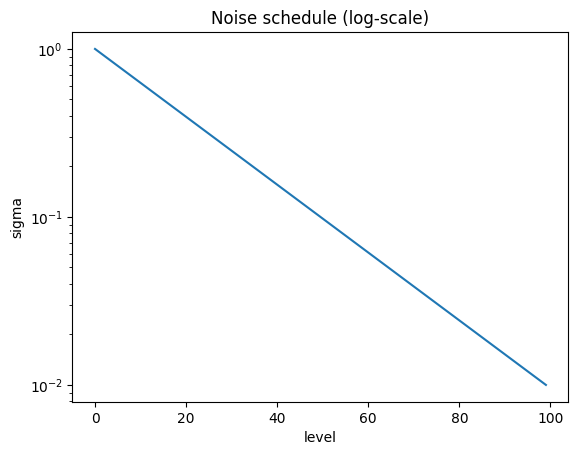

In [6]:
def geometric_sigmas(sigma_begin: float, sigma_end: float, num_classes: int, device: torch.device) -> torch.Tensor:
    sigmas = torch.exp(torch.linspace(math.log(sigma_begin), math.log(sigma_end), num_classes, device=device))
    return sigmas

num_classes = int(cfg["noise"]["num_classes"])
sigmas = geometric_sigmas(
    sigma_begin=float(cfg["noise"]["sigma_begin"]),
    sigma_end=float(cfg["noise"]["sigma_end"]),
    num_classes=num_classes,
    device=device,
)
print("sigmas[0], sigmas[-1] =", float(sigmas[0]), float(sigmas[-1]))

plt.plot(sigmas.detach().cpu().numpy())
plt.yscale("log")
plt.title("Noise schedule (log-scale)")
plt.xlabel("level")
plt.ylabel("sigma")
plt.show()


## Score model $s_\theta(x,\sigma)$

A simple MLP that conditions on $\sigma$ via a learned embedding.


In [7]:
class ScoreMLP(nn.Module):
    def __init__(self, n: int, num_classes: int, hidden_dim: int = 256, num_layers: int = 4):
        super().__init__()
        self.n = n
        self.sigma_embed = nn.Embedding(num_classes, hidden_dim)

        layers = []
        in_dim = n + hidden_dim
        for i in range(num_layers - 1):
            layers.append(nn.Linear(in_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, n))
        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        emb = self.sigma_embed(labels)
        h = torch.cat([x, emb], dim=1)
        return self.net(h)

model = ScoreMLP(
    n=n,
    num_classes=num_classes,
    hidden_dim=int(cfg["model"]["hidden_dim"]),
    num_layers=int(cfg["model"]["num_layers"]),
).to(device)
print("#params:", sum(p.numel() for p in model.parameters()))


#params: 487683


## CO-DSM loss

For a batch of clean binary samples $x$, we sample a noise index $c$ and set $\sigma=\sigma_c$.
Then we compute:

- energy scale: $a(x)=E(x)$ (clipped to avoid division by 0)
- perturbed sample: $\tilde x = x + \sigma\,a(x)\,\varepsilon$
- target score: $-\varepsilon/(\sigma a(x))$
- annealing weight: $\lambda(\sigma)=\sigma^{p}$ (default $p=2$)

and regress $s_\theta(\tilde x, c)$ to this target.


In [8]:
def co_dsm_loss(
    model: nn.Module,
    x: torch.Tensor,
    Q: torch.Tensor,
    sigmas: torch.Tensor,
    energy_floor: float = 1e-3,
    anneal_power: float = 2.0,
) -> torch.Tensor:
    B, n = x.shape
    labels = torch.randint(0, sigmas.shape[0], (B,), device=x.device)
    sigma = sigmas[labels].view(B, 1)

    energy = qubo_energy(x, Q).view(B, 1)
    energy = torch.clamp(energy, min=energy_floor)

    eps = torch.randn_like(x)
    x_tilde = x + sigma * energy * eps
    target = -eps / (sigma * energy)

    score = model(x_tilde, labels)
    diff = (score - target).view(B, -1)
    loss = 0.5 * (diff ** 2).sum(dim=1) * (sigma*energy).view(B).pow(anneal_power)
    return loss.mean()

# smoke test
x = sample_binary_batch(16, n, device)
loss = co_dsm_loss(model, x, Q, sigmas, anneal_power=float(cfg["loss"]["anneal_power"]))
print("loss:", float(loss))

loss: 1.967053771018982


## 2D / 3D toy cases (figures)

Small dimensions make it easy to visualize the **energy landscape** and a few **Langevin trajectories**.
This section is self-contained and does not modify the main experiment (`n=32`).

Tip for reports: use `plt.savefig("name.png", dpi=200, bbox_inches="tight")` right after a figure.


Q_2d is:  tensor([[-1.0443,  1.4396],
        [-1.8110, -0.6734]], device='cuda:0')


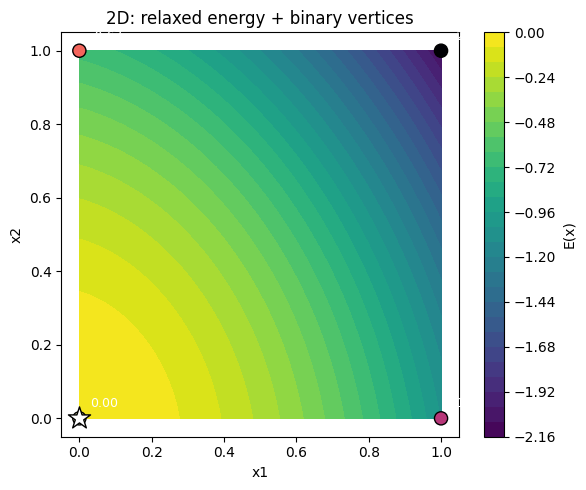

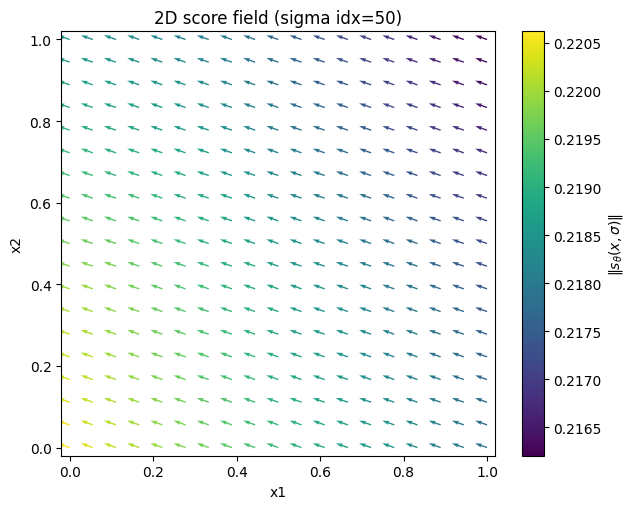

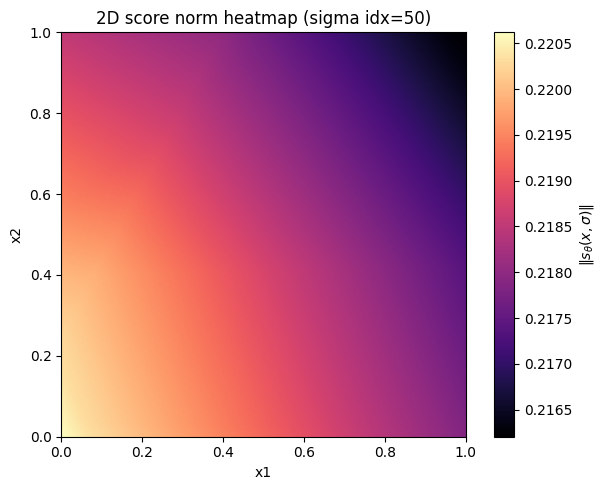

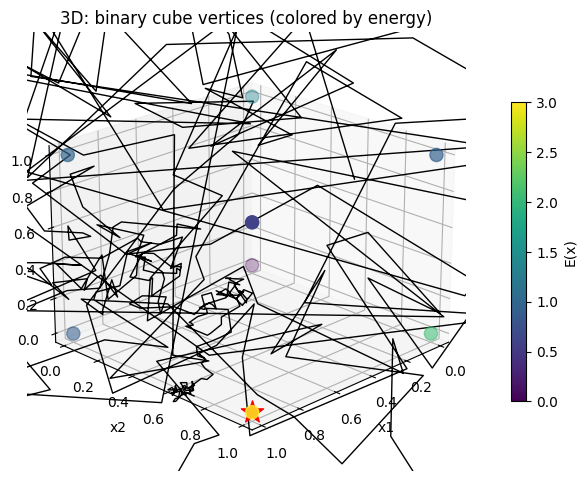

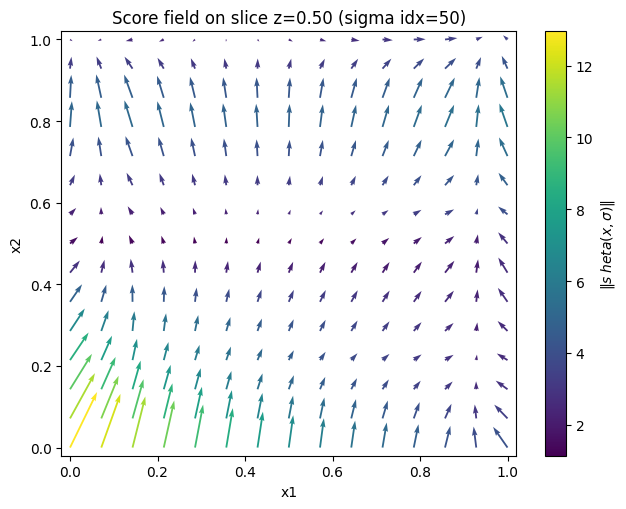

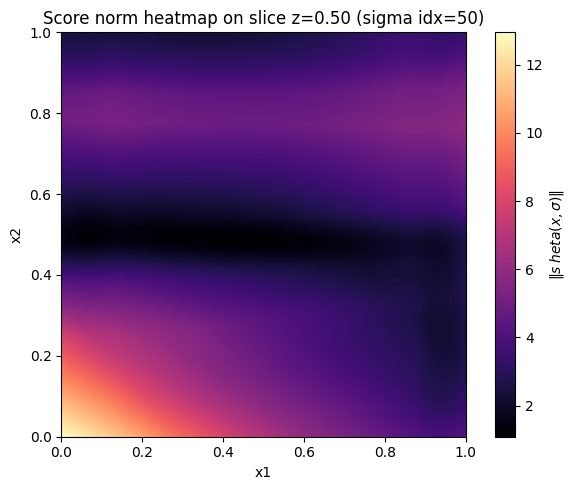

In [9]:
with temp_seed(int(cfg["toy"]["seed"])):
    # Q_2d = make_psd_qubo(2, rank=2, scale=1.0).to(device)
    Q_2d = make_qubo(2).to(device)
    # Make the (0,1) clearly dominant
    # Q_2d[0][0] = 10
    # Q_2d[0][1] = -3
    # Q_2d[1][1] = -3
    # Q_2d[1][0] = -3
    print("Q_2d is: ", Q_2d)
    
    Q_3d = make_psd_qubo(3, rank=3, scale=1.0).to(device)
    # Q_3d = make_qubo(3).to(device)
    
    toy_train = cfg["toy"]["train"]
    toy_sample = cfg["toy"]["sample"]

    model_2d, _ = train_score_model(
        2,
        Q_2d,
        sigmas,
        steps=int(toy_train["steps_2d"]),
        batch_size=int(toy_train["batch_size"]),
        lr=float(toy_train["lr"]),
        hidden_dim=int(toy_train["hidden_dim_2d"]),
        num_layers=int(toy_train["num_layers"]),
        anneal_power=float(cfg["loss"]["anneal_power"]),
    )
    trace_2d = annealed_langevin_trace(
        model_2d,
        sigmas,
        n=2,
        num_samples=1,
        n_steps_each=int(toy_sample["n_steps_each"]),
        step_lr=float(toy_sample["step_lr"]),
        device=device,
        init=str(toy_sample["init"]),
    )[:, 0]
    # plot_qubo_2d(Q_2d, trace_xy=trace_2d)
    plot_qubo_2d(Q_2d, trace_xy = None)
    
    sv2 = cfg["toy"]["score_viz_2d"]
    plot_score_field_2d(
        model_2d,
        sigma_index=int(sv2["sigma_index"]),
        quiver_res=int(sv2["quiver_res"]),
        norm_res=int(sv2["norm_res"]),
    )

    model_3d, _ = train_score_model(
        3,
        Q_3d,
        sigmas,
        steps=int(toy_train["steps_3d"]),
        batch_size=int(toy_train["batch_size"]),
        lr=float(toy_train["lr"]),
        hidden_dim=int(toy_train["hidden_dim_3d"]),
        num_layers=int(toy_train["num_layers"]),
        anneal_power=float(cfg["loss"]["anneal_power"]),
    )
    trace_3d = annealed_langevin_trace(
        model_3d,
        sigmas,
        n=3,
        num_samples=1,
        n_steps_each=int(toy_sample["n_steps_each"]),
        step_lr=float(toy_sample["step_lr"]),
        device=device,
        init=str(toy_sample["init"]),
    )[:, 0]
    plot_qubo_3d(Q_3d, trace_xyz=trace_3d)

    sv = cfg["toy"]["score_viz"]
    plot_score_field_3d_slice(
        model_3d,
        sigma_index=int(sv["sigma_index"]),
        z=float(sv["z"]),
        quiver_res=int(sv["quiver_res"]),
        norm_res=int(sv["norm_res"]),
    )

## Training

This is a minimal training loop. For a real experiment, increase `steps`, tune `lr`, and consider EMA.

If you only need quick figures/debugging, keep `steps` small (the toy section is designed for that).


step=  200 loss=1.480272
step=  400 loss=1.500615
step=  600 loss=1.399388
step=  800 loss=1.405040
step= 1000 loss=1.404210
step= 1200 loss=1.383346
step= 1400 loss=1.384857
step= 1600 loss=1.369213
step= 1800 loss=1.314081
step= 2000 loss=1.400762
step= 2200 loss=1.426182
step= 2400 loss=1.344788
step= 2600 loss=1.353492
step= 2800 loss=1.371019
step= 3000 loss=1.368600
step= 3200 loss=1.367296
step= 3400 loss=1.472425
step= 3600 loss=1.377598
step= 3800 loss=1.294687
step= 4000 loss=1.344014
step= 4200 loss=1.448104
step= 4400 loss=1.415227
step= 4600 loss=1.274932
step= 4800 loss=1.314595
step= 5000 loss=1.471604
step= 5200 loss=1.411366
step= 5400 loss=1.300872
step= 5600 loss=1.448807
step= 5800 loss=1.284803
step= 6000 loss=1.468775
step= 6200 loss=1.358425
step= 6400 loss=1.325723
step= 6600 loss=1.443094
step= 6800 loss=1.425990
step= 7000 loss=1.313940
step= 7200 loss=1.373649
step= 7400 loss=1.508085
step= 7600 loss=1.330936
step= 7800 loss=1.499879
step= 8000 loss=1.312456


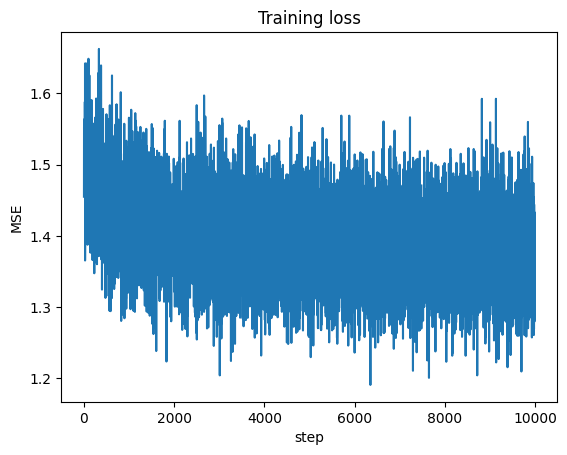

In [10]:
lr = float(cfg["train"]["lr"])
steps = int(cfg["train"]["steps"])
batch_size = int(cfg["train"]["batch_size"])

opt = torch.optim.Adam(model.parameters(), lr=lr)
model.train()

loss_hist = []
for step in range(1, steps + 1):
    x = sample_binary_batch(batch_size, n, device)
    loss = co_dsm_loss(model, x, Q, sigmas, anneal_power=float(cfg["loss"]["anneal_power"]))

    opt.zero_grad(set_to_none=True)
    loss.backward()
    opt.step()

    loss_hist.append(float(loss.detach().cpu()))
    if step % 200 == 0:
        print(f"step={step:5d} loss={loss_hist[-1]:.6f}")

plt.plot(loss_hist)
plt.title("Training loss")
plt.xlabel("step")
plt.ylabel("MSE")
plt.show()


## Annealed Langevin sampling + projection to $\{0,1\}^n$

We run Langevin dynamics over decreasing $\sigma$ and then threshold the final vector at 0.5.

The most sensitive sampling knobs are `n_steps_each` and `step_lr`.


Projected energy: min/mean/max = 3.362262487411499 3.9539060592651367 4.785442352294922


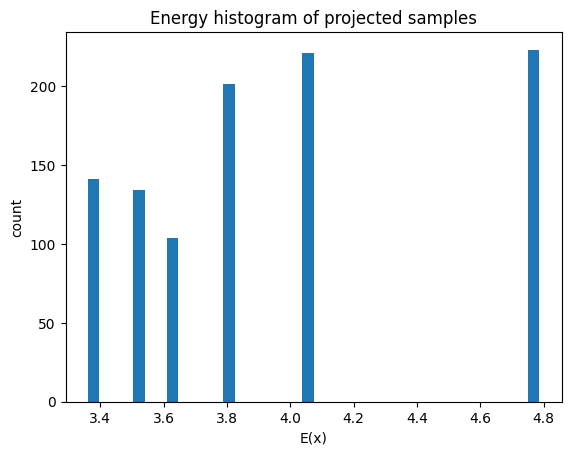

best energy: 4.785442352294922
best x (first 64 bits): [1 0 1]


In [26]:
@torch.no_grad()
def annealed_langevin(
    model: nn.Module,
    sigmas: torch.Tensor,
    n: int,
    num_samples: int,
    n_steps_each: int,
    step_lr: float,
    device: torch.device,
    init: str = "gaussian",
) -> torch.Tensor:
    if init == "gaussian":
        x = torch.randn(num_samples, n, device=device)
    elif init == "uniform01":
        x = torch.rand(num_samples, n, device=device)
    else:
        raise ValueError(f"unknown init={init}")

    for c, sigma in enumerate(sigmas):
        labels = torch.full((num_samples,), c, device=device, dtype=torch.long)
        step_size = step_lr * (sigma / sigmas[-1]) ** 2
        for _ in range(n_steps_each):
            grad = model(x, labels)
            noise = torch.randn_like(x)
            x = x + step_size * grad + noise * math.sqrt(2.0 * step_size)
    return x

model.eval()
samples = annealed_langevin(
    model,
    sigmas,
    n=n,
    num_samples=int(cfg["sample"]["num_samples"]),
    n_steps_each=int(cfg["sample"]["n_steps_each"]),
    step_lr=float(cfg["sample"]["step_lr"]),
    device=device,
    init=str(cfg["sample"]["init"]),
)

x_proj = (samples > 0.5).float()
E_proj = qubo_energy(x_proj, Q)
print("Projected energy: min/mean/max =", float(E_proj.min()), float(E_proj.mean()), float(E_proj.max()))

plt.hist(E_proj.detach().cpu().numpy(), bins=40)
plt.title("Energy histogram of projected samples")
plt.xlabel("E(x)")
plt.ylabel("count")
plt.show()

best_idx = torch.argmax(E_proj)
best_x = x_proj[best_idx]
best_E = E_proj[best_idx]
print("best energy:", float(best_E))
print("best x (first 64 bits):", best_x[:64].int().detach().cpu().numpy())


## Langevin trajectory diagnostics

Record a few chains during sampling, then track how the (projected) objective $E(x)$ evolves.


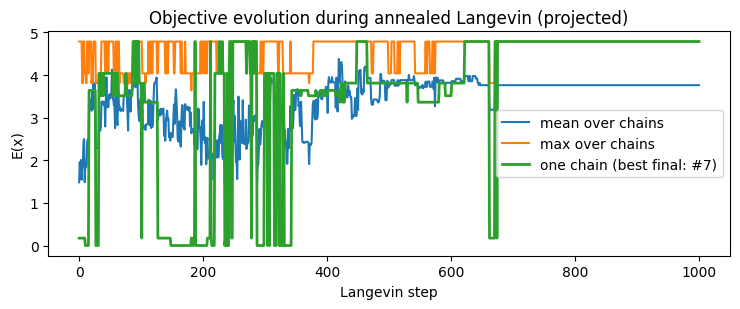

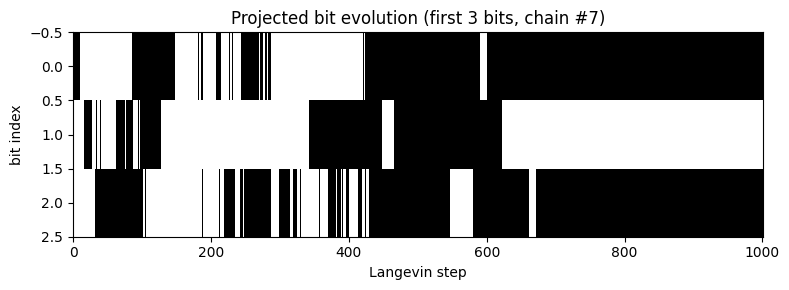

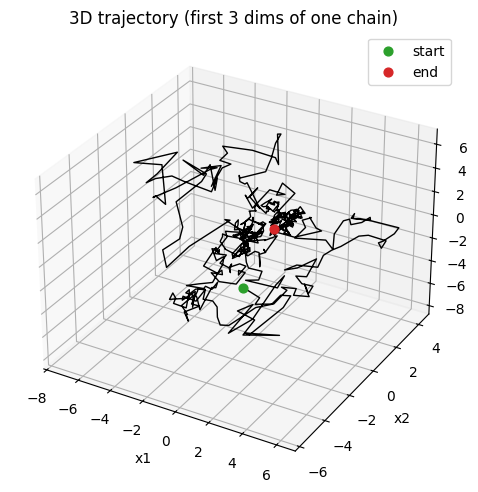

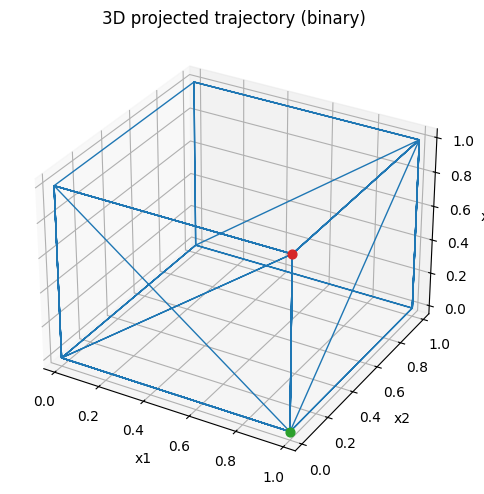

In [14]:
trace = annealed_langevin_trace(
    model,
    sigmas,
    n=n,
    num_samples=int(cfg["diagnostics"]["num_chains"]),
    n_steps_each=int(cfg["diagnostics"]["n_steps_each"]),
    step_lr=float(cfg["diagnostics"]["step_lr"]),
    device=device,
    init=str(cfg["diagnostics"]["init"]),
)

x_proj_t = (trace > 0.5).float()  # (T, B, n)
T, B, _ = x_proj_t.shape

E_t = qubo_energy(x_proj_t.reshape(T * B, n), Q).view(T, B)

best_chain = torch.argmax(E_t[-1]).item()
E_best = E_t[:, best_chain].detach().cpu().numpy()
E_mean = E_t.mean(dim=1).detach().cpu().numpy()
E_max = E_t.max(dim=1).values.detach().cpu().numpy()

plt.figure(figsize=(7.5, 3.2))
plt.plot(E_mean, label="mean over chains")
plt.plot(E_max, label="max over chains")
plt.plot(E_best, label=f"one chain (best final: #{best_chain})", lw=2)
plt.title("Objective evolution during annealed Langevin (projected)")
plt.xlabel("Langevin step")
plt.ylabel("E(x)")
plt.legend()
plt.tight_layout()
plt.show()

k = min(n, 32)
bits = x_proj_t[:, best_chain, :k].T.detach().cpu().numpy()
plt.figure(figsize=(8, 3.0))
plt.imshow(bits, aspect="auto", cmap="Greys", interpolation="nearest")
plt.title(f"Projected bit evolution (first {k} bits, chain #{best_chain})")
plt.xlabel("Langevin step")
plt.ylabel("bit index")
plt.tight_layout()
plt.show()

if n >= 3:
    xyz = trace[:, best_chain, :3].detach().cpu().numpy()
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(xyz[:, 0], xyz[:, 1], xyz[:, 2], color="black", lw=1.0)
    ax.scatter([xyz[0, 0]], [xyz[0, 1]], [xyz[0, 2]], c="tab:green", s=40, label="start")
    ax.scatter([xyz[-1, 0]], [xyz[-1, 1]], [xyz[-1, 2]], c="tab:red", s=40, label="end")
    ax.set_title("3D trajectory (first 3 dims of one chain)")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    ax.legend()
    plt.tight_layout()
    plt.show()

    xyzp = x_proj_t[:, best_chain, :3].detach().cpu().numpy()
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot(xyzp[:, 0], xyzp[:, 1], xyzp[:, 2], color="tab:blue", lw=1.0)
    ax.scatter([xyzp[0, 0]], [xyzp[0, 1]], [xyzp[0, 2]], c="tab:green", s=40)
    ax.scatter([xyzp[-1, 0]], [xyzp[-1, 1]], [xyzp[-1, 2]], c="tab:red", s=40)
    ax.set_title("3D projected trajectory (binary)")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_zlim(-0.05, 1.05)
    plt.tight_layout()
    plt.show()


## Quick comparison vs random

A simple sanity check: compare the sampled energies against uniformly random binary vectors.


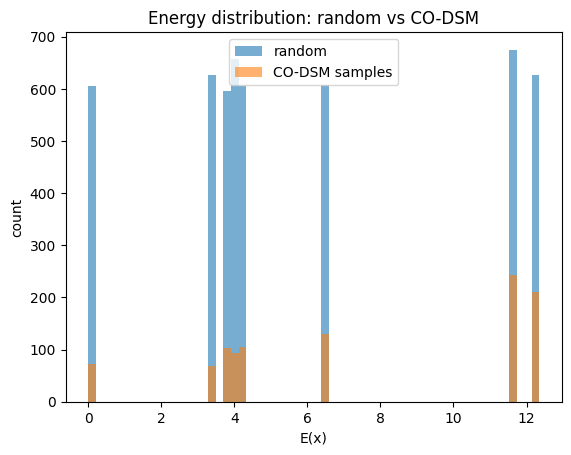

best(random)  = 12.343994140625
best(CO-DSM)  = 12.343994140625
mean(random)  = 5.820681095123291
mean(CO-DSM)  = 7.5337371826171875


In [193]:
x_rand = sample_binary_batch(int(cfg["eval"]["random_batch"]), n, device)
E_rand = qubo_energy(x_rand, Q)

plt.hist(E_rand.detach().cpu().numpy(), bins=60, alpha=0.6, label="random")
plt.hist(E_proj.detach().cpu().numpy(), bins=60, alpha=0.6, label="CO-DSM samples")
plt.title("Energy distribution: random vs CO-DSM")
plt.xlabel("E(x)")
plt.ylabel("count")
plt.legend()
plt.show()

print("best(random)  =", float(E_rand.max()))
print("best(CO-DSM)  =", float(E_proj.max()))
print("mean(random)  =", float(E_rand.mean()))
print("mean(CO-DSM)  =", float(E_proj.mean()))


## (Optional) Brute-force check for small n

If you set `n <= 20`, you can brute force the optimum and compare. This is only feasible for small dimensions.


In [194]:
def brute_force_best(Q: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    n = Q.shape[0]
    if n > 20:
        raise ValueError("Brute force only feasible for n<=20")
    all_x = torch.stack(
        [
            torch.tensor([(mask >> i) & 1 for i in range(n)], dtype=torch.float32)
            for mask in range(2**n)
        ],
        dim=0,
    ).to(Q.device)
    E = qubo_energy(all_x, Q)
    idx = torch.argmax(E)
    return all_x[idx], E[idx]

# Example usage:
n_small = 16
Q_small = make_psd_qubo(n_small, rank=8, scale=1.0).to(device)
x_star, E_star = brute_force_best(Q_small)
print("brute force best energy:", float(E_star))


brute force best energy: 105.48509979248047
